In [1]:
%load_ext autoreload
%autoreload 2
import features
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline


In [2]:
train, test, train_labels, specs = features.read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns


In [157]:
train.installation_id.unique().size

17000

In [158]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

In [159]:
train_labels.columns

Index(['game_session', 'installation_id', 'title', 'num_correct',
       'num_incorrect', 'accuracy', 'accuracy_group'],
      dtype='object')

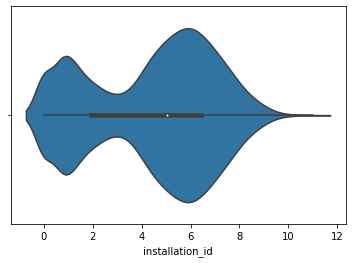

In [160]:
sns.violinplot(np.log(train.installation_id.value_counts()))

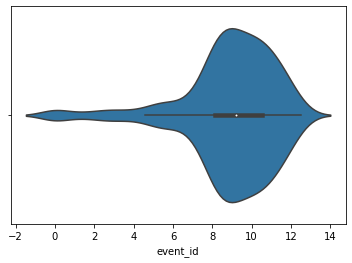

In [161]:
sns.violinplot(np.log(train.event_id.value_counts()))

In [3]:
def get_worst_score(group):
    return group.sort_values('accuracy_group').iloc[0]

labels = train_labels.groupby(['installation_id', 'title']).apply(get_worst_score).reset_index(drop=True)

## One installation example

In [64]:
train[(train.installation_id == '0006a69f')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
5334,832735e1,0721802df0531701,2019-08-29T16:33:53.227Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK
5335,ab3136ba,0721802df0531701,2019-08-29T16:33:56.880Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK
5336,832735e1,0721802df0531701,2019-08-29T16:34:11.881Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK
5337,ab3136ba,0721802df0531701,2019-08-29T16:34:15.480Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK


In [7]:
testing = train[(train.installation_id == '0006a69f')].merge(labels[labels.installation_id == '0006a69f'], on='installation_id')
groups = testing.groupby(['installation_id', 'game_session_y'])                                           
                                                             

In [8]:
groups

In [20]:
feats = groups \
        .apply(lambda x: features.summarize_events_before_game_session(x, game_session=x.name[1] if len(x.name) == 2 else '')) \
        .reset_index()

In [21]:
feats

,installation_id,game_session_y,event_count,game_time,num_unique_days,elapsed_days,last_world,last_game_session,type_counts,unique_game_sessions,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,0006a69f,77b8ee947eb84b4e,1230,1135,1,0,TREETOPCITY,77b8ee947eb84b4e,Activity 556 Game 525 Assessment...,26,Bird Measurer (Assessment),0,11,0.0,0
1,0006a69f,9501794defd84e4d,2201,3488,1,0,TREETOPCITY,9501794defd84e4d,Activity 1103 Game 845 Assessme...,48,Mushroom Sorter (Assessment),1,1,0.5,2


## Run on all data

In [23]:
feats, labels = features.basic_user_features_transform(train, labels)

In [67]:
# Save checkpoint
feats.to_csv('installation_features.csv', index=False)
labels.to_csv('installation_labels.csv', index=False)

In [24]:
feats.shape

(9386, 10)

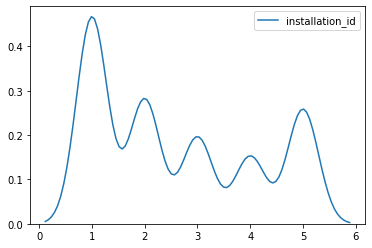

In [66]:
# installation ids have between 1 - 5 assessments in the training data
sns.kdeplot(labels.installation_id.value_counts())

In [33]:
feats.head()

,event_count,game_time,num_unique_days,elapsed_days,last_world,unique_game_sessions,activity_ct,game_ct,assessment_ct,clip_ct
0,1230,1135,1,0,TREETOPCITY,26,556.0,525.0,135.0,14.0
1,2201,3488,1,0,TREETOPCITY,48,1103.0,845.0,229.0,24.0
2,1566,1342,2,1,MAGMAPEAK,26,894.0,633.0,24.0,15.0
3,2222,2063,4,18,TREETOPCITY,48,1206.0,643.0,343.0,30.0
4,2014,1835,4,18,TREETOPCITY,44,1206.0,637.0,143.0,28.0


In [27]:
labels.head()

,title_y,num_correct,num_incorrect,accuracy,accuracy_group,installation_id,game_session_y
0,Bird Measurer (Assessment),0,11,0.0,0,0006a69f,77b8ee947eb84b4e
1,Mushroom Sorter (Assessment),1,1,0.5,2,0006a69f,9501794defd84e4d
2,Cauldron Filler (Assessment),1,0,1.0,3,0006c192,197a373a77101924
3,Bird Measurer (Assessment),1,1,0.5,2,0006c192,957406a905d59afd
4,Mushroom Sorter (Assessment),0,4,0.0,0,0006c192,b2297d292892745a


In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
import inspect

In [30]:
feature_pipe = features.get_data_processing_pipe(feats,log_features=['game_time', 'event_count'], categorical_features=['last_world'])

In [36]:
feats[:1000]

,event_count,game_time,num_unique_days,elapsed_days,last_world,unique_game_sessions,activity_ct,game_ct,assessment_ct,clip_ct
0,1230,1135,1,0,TREETOPCITY,26,556.0,525.0,135.0,14.0
1,2201,3488,1,0,TREETOPCITY,48,1103.0,845.0,229.0,24.0
2,1566,1342,2,1,MAGMAPEAK,26,894.0,633.0,24.0,15.0
3,2222,2063,4,18,TREETOPCITY,48,1206.0,643.0,343.0,30.0
4,2014,1835,4,18,TREETOPCITY,44,1206.0,637.0,143.0,28.0
...,...,...,...,...,...,...,...,...,...,...
995,60,68,1,0,TREETOPCITY,6,0.0,21.0,35.0,4.0
996,1068,1221,5,82,MAGMAPEAK,37,355.0,484.0,87.0,24.0
997,1468,1722,1,0,CRYSTALCAVES,31,333.0,852.0,266.0,17.0
998,384,322,1,0,TREETOPCITY,11,122.0,217.0,38.0,7.0


In [34]:
f = feature_pipe.fit_transform(feats[:1000])

In [37]:
f[0]

array([-0.58823969, -0.57109623, -0.14503066,  0.0607788 , -0.1039365 ,
       -0.16982723, -0.10627748,  0.12066108,  0.46398825,  0.        ,
        0.        ,  1.        ])

In [38]:
f[1]

array([-0.58823969, -0.57109623,  0.27396796,  0.74117096,  0.20558543,
        0.05003504,  0.22234801,  0.91260474,  0.95262231,  0.        ,
        0.        ,  1.        ])

In [ ]:
f[2]

In [49]:
lr_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', LogisticRegression())])

rf_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', RandomForestClassifier())])

In [46]:
lr_cv = GridSearchCV(lr_pipe, scoring='accuracy', param_grid={'clf__C': [10**i for i in range(-3, 4)], 'clf__max_iter': [1000]})
lr_cv.fit(feats, labels.accuracy_group)
pd.DataFrame(lr_cv.cv_results_)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                   

In [54]:
rf_cv = GridSearchCV(rf_pipe, scoring='accuracy', param_grid={'clf__max_depth': [1, 3, 5, 7, 9], 'clf__n_estimators': [100, 500, 1000]})
rf_cv.fit(feats, labels.accuracy_group)
pd.DataFrame(rf_cv.cv_results_)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                   

In [60]:
print(inspect.getsource(features))

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape